In [6]:
from synutility.SynIO.data_type import load_from_pickle
import networkx as nx
from math import isclose
import time
import numpy as np

from create_partitions_by_invariant import create_partitions_by_invariant
from cluster_reaction_centers import cluster_reaction_centers

In [7]:
def aggregate_charge_and_element_attributes(reaction):
    for node, attributes in reaction.nodes.data():
        attributes["element_charge"] = f"{attributes['element']}{attributes['charge']}"

    return reaction

data = load_from_pickle("C:/Users/Mark/Documents/graph_theory/ITS_graphs.pkl.gz")
reactions = [reaction["ITS"] for reaction in data]
reactions = [aggregate_charge_and_element_attributes(reaction) for reaction in reactions]

In [8]:
def edge_count_invariant(reaction_center, partition_representant_reaction_center):
    edge_count_reaction_center = len(reaction_center.edges)
    edge_count_partition_representant = len(partition_representant_reaction_center.edges)

    return edge_count_reaction_center == edge_count_partition_representant

In [9]:
def vertex_count_invariant(reaction_center, partition_representant_reaction_center):
    vertex_count_reaction_center = len(reaction_center.nodes)
    vertex_count_partition_representant = len(partition_representant_reaction_center.nodes)

    return vertex_count_reaction_center == vertex_count_partition_representant

In [10]:
# TODO: check if this implementation for degree invariant is actually correct

def vertex_degree_invariant(reaction_center, partition_representant_reaction_center):
    reaction_center_degrees = sorted([degree for node, degree in list(reaction_center.degree)])
    partition_representant_degrees = sorted([degree for node, degree in list(partition_representant_reaction_center.degree)])

    return reaction_center_degrees == partition_representant_degrees

In [11]:
def algebraic_connectivity_invariant(reaction_center, partition_representant_reaction_center):
    algebraic_connectivity_reaction_center = nx.algebraic_connectivity(reaction_center)
    algebraic_connectivity_partition_representant_reaction_center = nx.algebraic_connectivity(partition_representant_reaction_center)

    return isclose(algebraic_connectivity_reaction_center, algebraic_connectivity_partition_representant_reaction_center, rel_tol=1e-6)

In [12]:
def rank_invariant(reaction_center, partition_representant_reaction_center):
    reaction_center_rank = float(np.linalg.matrix_rank(nx.to_pandas_adjacency(reaction_center).values))
    partition_representant_rank = float(np.linalg.matrix_rank(nx.to_pandas_adjacency(partition_representant_reaction_center).values))

    return isclose(reaction_center_rank, partition_representant_rank, rel_tol=1e-6)

In [13]:
def weisfeiler_lehman_invariant(reaction_center, partition_representant_reaction_center):  
    edge_attribute = 'order'
    node_attribute = 'element_charge'

    reaction_center_hash = nx.weisfeiler_lehman_graph_hash(reaction_center, edge_attr=edge_attribute, node_attr=node_attribute, iterations = 1)
    partition_representant_hash = nx.weisfeiler_lehman_graph_hash(partition_representant_reaction_center, edge_attr=edge_attribute, node_attr=node_attribute, iterations = 1)

    return reaction_center_hash == partition_representant_hash

In [14]:
def av_length_invariant(reaction_center, partition_representant_reaction_center):
    if nx.is_connected(reaction_center) and nx.is_connected(partition_representant_reaction_center):
        avg_path_length_reaction_center = nx.average_shortest_path_length(reaction_center)
        avg_path_length_partition_representant = nx.average_shortest_path_length(partition_representant_reaction_center)

        return isclose(avg_path_length_reaction_center, avg_path_length_partition_representant, rel_tol=1e-6)
    else:
        return True

In [15]:
def graph_diameter_invariant(reaction_center, partition_representant_reaction_center):
    if nx.is_connected(reaction_center) and nx.is_connected(partition_representant_reaction_center):
        reaction_center_diameter = nx.diameter(reaction_center)
        partition_representant_reaction_center_diameter = nx.diameter(partition_representant_reaction_center)

        return reaction_center_diameter == partition_representant_reaction_center_diameter
    else:
        return True


In [16]:
start_time = time.time()

invariant_check_function = av_length_invariant
pre_filtered_partitions = create_partitions_by_invariant(reactions, invariant_check_function)

overall_partitions = []

for pre_filtered_partition in pre_filtered_partitions:
        partitions = cluster_reaction_centers(pre_filtered_partition)
        overall_partitions = overall_partitions + partitions

end_time = time.time()

# Summary

In [17]:
elapsed_time = end_time - start_time

print(f"Time elapsed: {elapsed_time:.2f} seconds")

print(f"Partitions found: {len(pre_filtered_partitions)}")

Time elapsed: 221.35 seconds
Partitions found: 52


IndexError: list index out of range

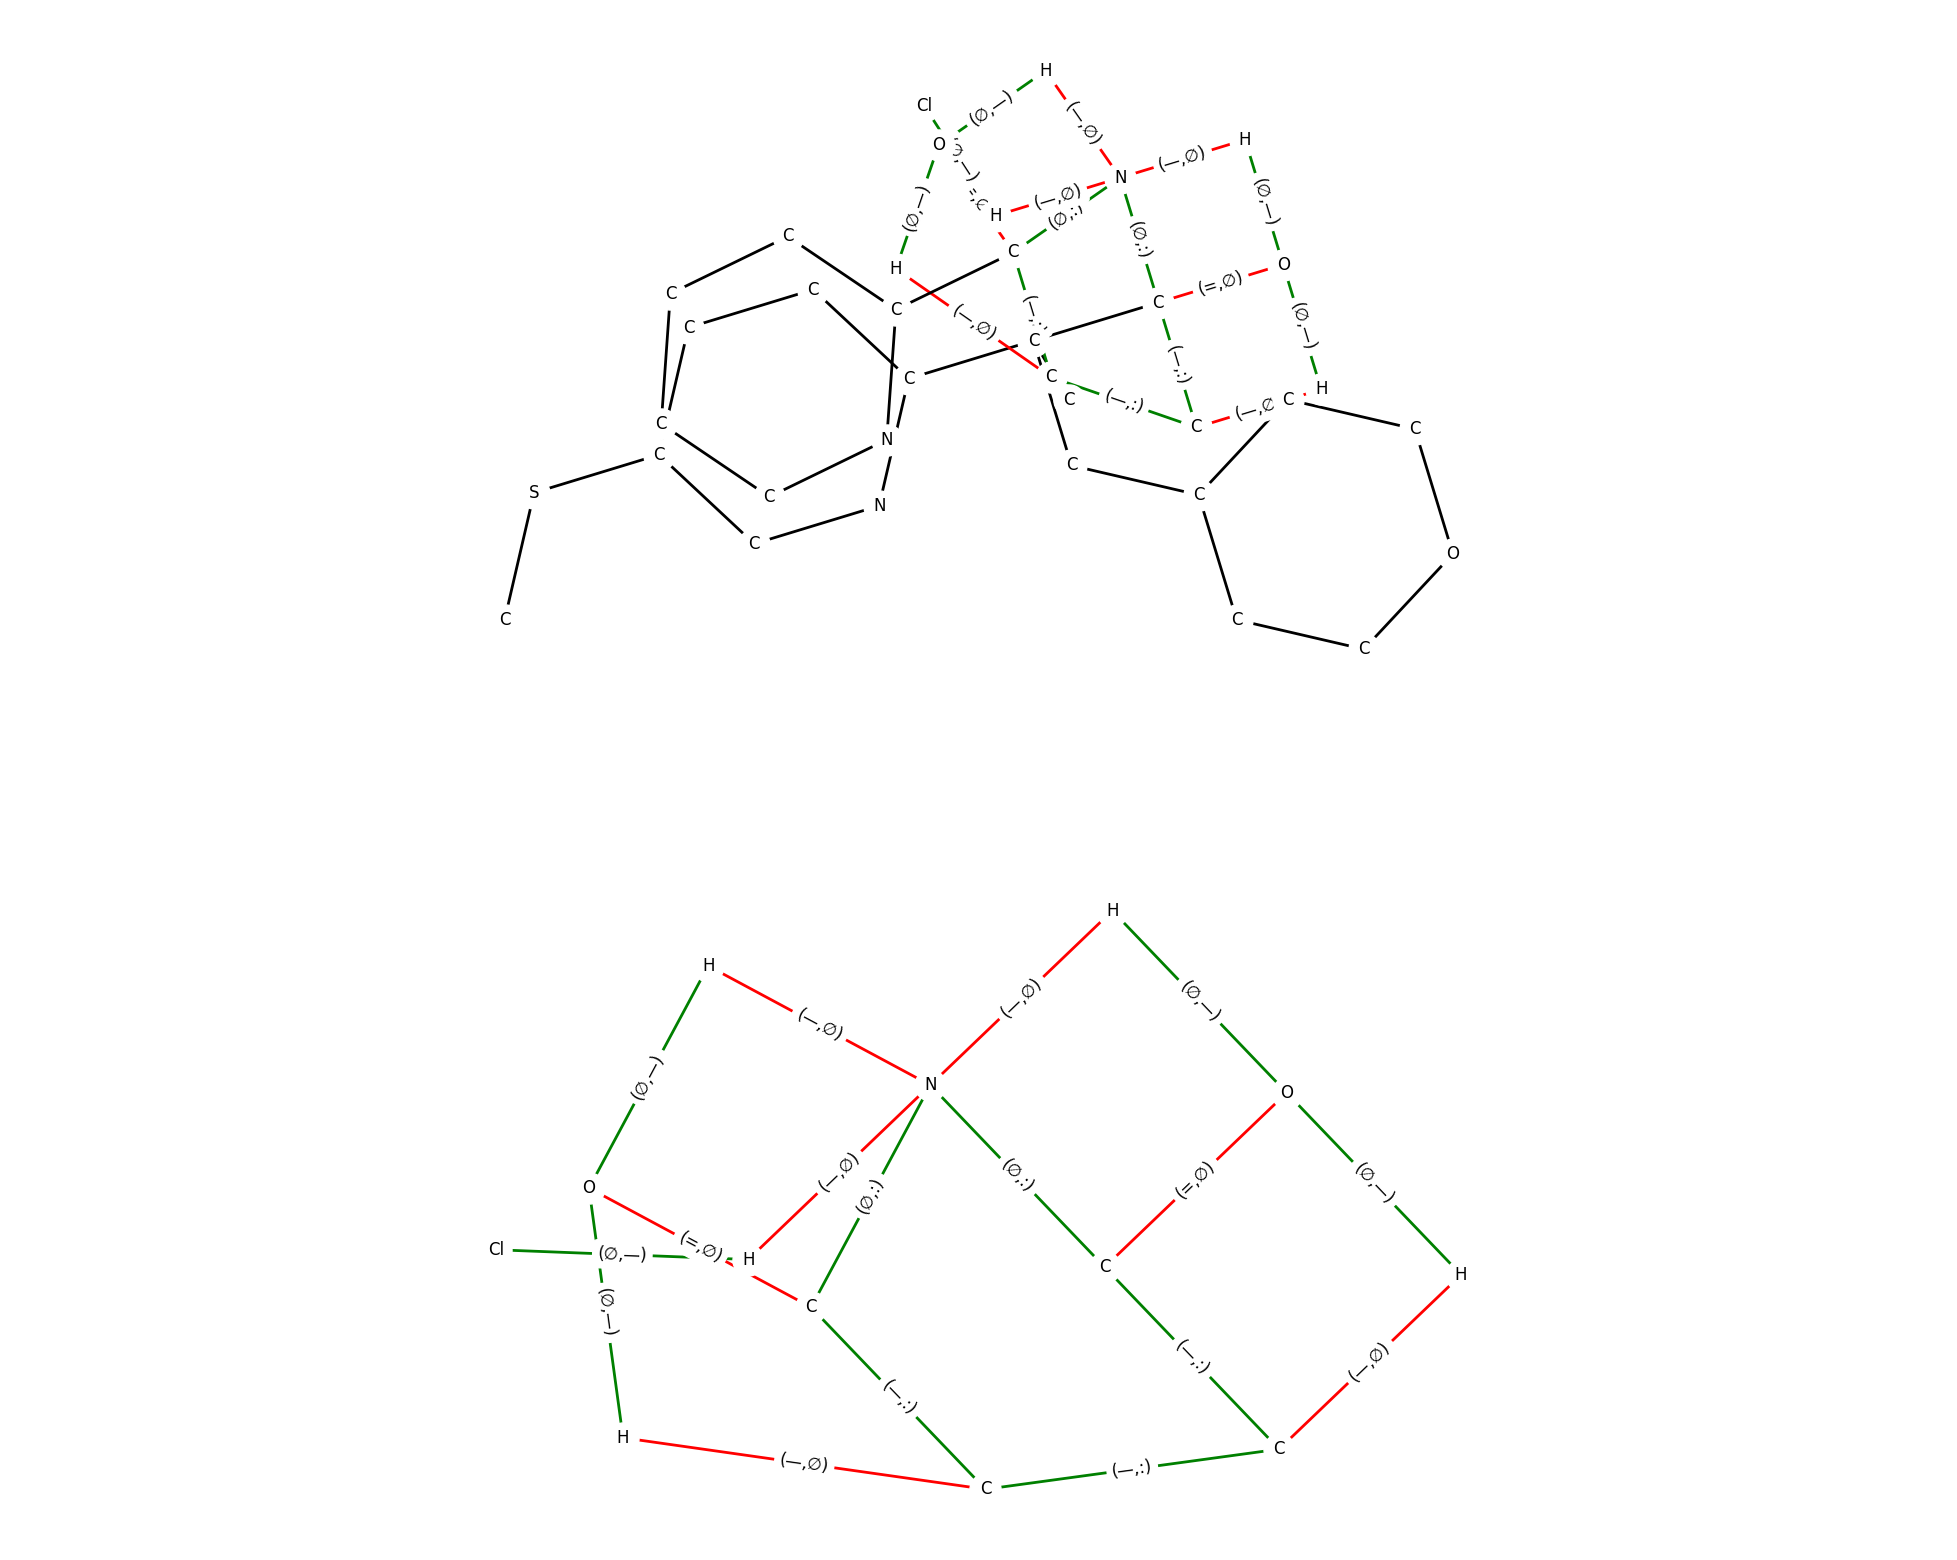

In [18]:
from visualize_graph import visualize_graph

current_partition = partitions[0]

visualize_graph(current_partition[0], with_reaction_center=True)
visualize_graph(current_partition[1], with_reaction_center=True)

# multistage invariant partitioning / hierarchical clustering

In [19]:
invariant_config = {
    0: edge_count_invariant,
    1: vertex_degree_invariant,
    2: weisfeiler_lehman_invariant 
} 

""" invariant_config = {
    0: rank_invariant,
    1: vertex_count_invariant,
    2: edge_count_invariant,
    3: vertex_degree_invariant,
    4: weisfeiler_lehman_invariant 
} """


""" invariant_config = {
    0: vertex_count_invariant,
    1: edge_count_invariant,
    2: vertex_degree_invariant,
    3: rank_invariant,
    4: weisfeiler_lehman_invariant 
} 
 """

# invariant_config = {
#     0: edge_count_invariant,
# }

' invariant_config = {\n    0: vertex_count_invariant,\n    1: edge_count_invariant,\n    2: vertex_degree_invariant,\n    3: rank_invariant,\n    4: weisfeiler_lehman_invariant \n} \n '

In [20]:
partitions = []

start_time = time.time()

for invariant_index in range(0, len(invariant_config.values())):
    invariant_check_function = invariant_config[invariant_index]

    if invariant_index == 0:
        partitions = create_partitions_by_invariant(reactions, invariant_check_function)
    else:
         for index, partition in enumerate(partitions):
            del partitions[index]
            
            sub_partitions = create_partitions_by_invariant(partition, invariant_check_function)

            partitions = partitions + sub_partitions

    print(f"{invariant_index}'s partition length = {len(partitions)}")

overall_partitions = []

for pre_filtered_partition in partitions:
    p = cluster_reaction_centers(pre_filtered_partition)
    overall_partitions = overall_partitions + p 

end_time = time.time()

0's partition length = 16
1's partition length = 50
2's partition length = 218


- After each prepartitioning the usual nx.isomorphism check must be executed
- the goal is to optimally reduce the complete runtime by prepartitioning

In [21]:
elapsed_time = end_time - start_time

print(f"Time elapsed: {elapsed_time:.2f} seconds")

print(f"Partitions via invariants found: {len(partitions)}")
print(f"Partitions finally found: {len(overall_partitions)}")

Time elapsed: 28.76 seconds
Partitions via invariants found: 218
Partitions finally found: 277


In [15]:
number_of_elements_per_cluster = [(index, len(p)) for index, p in enumerate(partitions)]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data = number_of_elements_per_cluster
sorted_data = sorted(data, key=lambda x: x[1])

original_indices_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(32, 20))
plt.bar(range(len(values_sorted)), values_sorted, tick_label=original_indices_sorted, color='lightgreen', edgecolor='black')
plt.xlabel('Original Index', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Barplot with Values Sorted but Original Indices Shown', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
one_element_partitions = [p for p in number_of_elements_per_cluster if p[1] < 2]

len(one_element_partitions)

one_element_partitions[0]


In [ ]:
example_graph = partitions[one_element_partitions[7][0]][0]

visualize_graph(example_graph, with_reaction_center=True)

In [ ]:
two_element_partitions = [p for p in number_of_elements_per_cluster if p[1] == 2]

len(two_element_partitions)

two_element_partitions

example_graphs = partitions[two_element_partitions[0][0]]

visualize_graph(example_graphs[0], with_reaction_center=True)
visualize_graph(example_graphs[1], with_reaction_center=True)


In [ ]:
arr = [1, 2, 3, 4, 5]

del arr[4]

arr